# Brain Tumor Detection: EfficientNet, ResNet, XCeption
Source: https://www.kaggle.com/code/anitarostami/brain-tumor-detection-efficientnet-resnet-xception/notebook

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings

# Print Dataset
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset/brain.tar.gz
dataset/Testing/glioma/Te-glTr_0000.jpg
dataset/Testing/glioma/Te-glTr_0001.jpg
dataset/Testing/glioma/Te-glTr_0002.jpg
dataset/Testing/glioma/Te-glTr_0003.jpg
dataset/Testing/glioma/Te-glTr_0004.jpg
dataset/Testing/glioma/Te-glTr_0005.jpg
dataset/Testing/glioma/Te-glTr_0006.jpg
dataset/Testing/glioma/Te-glTr_0007.jpg
dataset/Testing/glioma/Te-glTr_0008.jpg
dataset/Testing/glioma/Te-glTr_0009.jpg
dataset/Testing/glioma/Te-gl_0010.jpg
dataset/Testing/glioma/Te-gl_0011.jpg
dataset/Testing/glioma/Te-gl_0012.jpg
dataset/Testing/glioma/Te-gl_0013.jpg
dataset/Testing/glioma/Te-gl_0014.jpg
dataset/Testing/glioma/Te-gl_0015.jpg
dataset/Testing/glioma/Te-gl_0017.jpg
dataset/Testing/glioma/Te-gl_0018.jpg
dataset/Testing/glioma/Te-gl_0019.jpg
dataset/Testing/glioma/Te-gl_0020.jpg
dataset/Testing/glioma/Te-gl_0021.jpg
dataset/Testing/glioma/Te-gl_0022.jpg
dataset/Testing/glioma/Te-gl_0023.jpg
dataset/Testing/glioma/Te-gl_0024.jpg
dataset/Testing/glioma/Te-gl_0025.jpg
dataset/T

### Data Preparation

In [9]:
X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']


image_size = 150
for i in labels:
    folderPath = os.path.join('dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:00<00:00, 1950.51it/s]


### Data Visualization

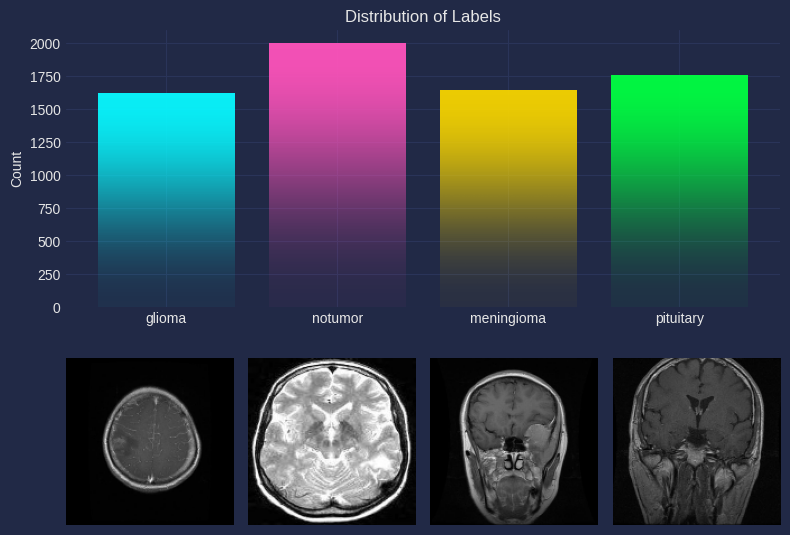

In [10]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

### Dataset Split and Train

In [11]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One Hot Encoding Labels

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

### EfficientNet

In [13]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1744524508.612976   81195 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 962 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

In [15]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [16]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 12, verbose = 1,
                    batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12


I0000 00:00:1744524619.506749   86075 service.cc:148] XLA service 0x7df6dc0b9350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744524619.506766   86075 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2025-04-13 02:10:19.941745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744524621.581196   86075 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-13 02:10:23.198746: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511_0', 8 bytes spill stores, 8 bytes spill loads

2025-04-13 02:10:23.419608: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_195

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_81195/3956955747.py", line 1, in <module>

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 808051344 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_49765]

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()


### Evaluation

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test))

### Prediction

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

## ResNet101

In [ ]:

# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test))

## Prediction

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

## XCeption

In [ ]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test))

### Prediction

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class] 

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()